In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
train = pd.read_csv("../work in progress/train.csv")
test = pd.read_csv("../work in progress/test.csv")

In [14]:
X = train.drop(columns = ['SalePrice'])
y = train['SalePrice']

### Helper function - Compute summary vectors

In [12]:
#Function to calculate a vector of mean and standard deviation values for each paramter

def compute_vectors(grid_search, trials):
    '''
    Takes a grid_search object and the number of trials as input
    '''
    mean_vec = np.zeros(trials)
    std_vec = np.zeros(trials)
    i = 0
    
    #Using Grid Search's 'cv_results' attribute to get mean and std for each paramter
    for mean_score, std_score in zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["std_test_score"]):
        mean_vec[i] = -mean_score
        # negative sign used with mean.score() to get positive mean squared error
        std_vec[i] = std_score
        i = i+1

    return mean_vec, std_vec

# Ridge Regression

In [91]:
#from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
ridge = Ridge(normalize = True)

# Defining set of regularization parameters - alpha 
# Taking 10 to the power of the set of numbers from -3 to 5 (with 100 intervals)
alpha_param = (10**np.linspace(start=-3, stop=2, num=50))

#Creating a parameters grid
param_grid = [{'alpha': alpha_param }]

#Running Grid Search over the alpha (regularization) parameter
ridge_model = GridSearchCV(ridge, param_grid, cv = 10, scoring = 'neg_mean_absolute_error')
ridge_model.fit(X, y)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-03, 1.26485522e-03, 1.59985872e-03, 2.02358965e-03,
       2.55954792e-03, 3.23745754e-03, 4.09491506e-03, 5.17947468e-03,
       6.5512855...
       1.84206997e+00, 2.32995181e+00, 2.94705170e+00, 3.72759372e+00,
       4.71486636e+00, 5.96362332e+00, 7.54312006e+00, 9.54095476e+00,
       1.20679264e+01, 1.52641797e+01, 1.93069773e+01, 2.44205309e+01,
       3.08884360e+01, 3.90693994e+01, 4.94171336e+01, 6.25055193e+01,
       7.90604321e+01, 1.00000000e+02])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

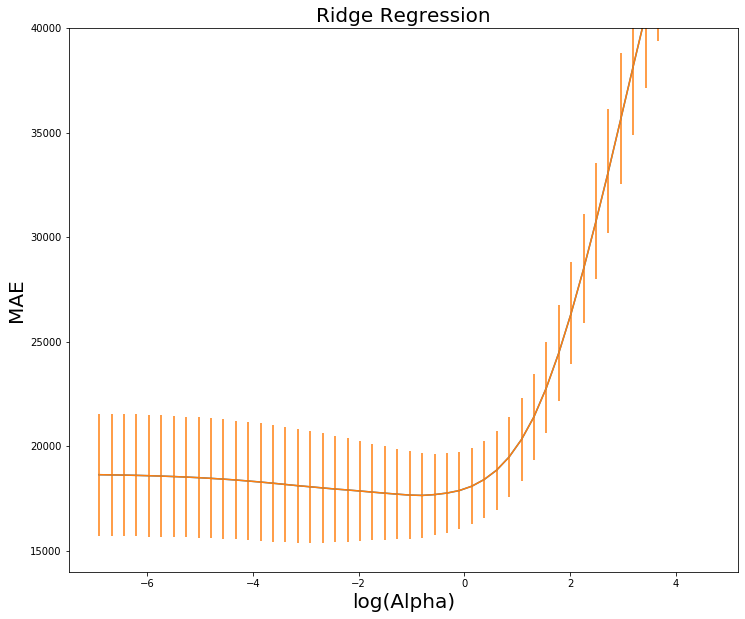

In [96]:
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(ridge_model, 50)

plt.figure(figsize=(12,10))
plt.title('Ridge Regression', fontsize= 20)
plt.plot(np.log(alpha_param), mean_vec)
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("log(Alpha)", fontsize= 20)
plt.ylim(14000, 40000)
plt.show()

In [108]:
# print values
ridge_results = pd.DataFrame(ridge_model.cv_results_)
ridge_results = ridge_results[['params','mean_test_score','std_test_score', 'rank_test_score']]
ridge_results = ridge_results.sort_values(by=['rank_test_score'])

In [110]:
ridge_results.head(15)

,params,mean_test_score,std_test_score,rank_test_score
26,{'alpha': 0.4498432668969444},-17652.880445,2016.699558,1
25,{'alpha': 0.35564803062231287},-17669.741159,2093.917356,2
27,{'alpha': 0.5689866029018299},-17693.262226,1947.810801,3
24,{'alpha': 0.28117686979742307},-17713.179413,2167.717396,4
23,{'alpha': 0.22229964825261955},-17760.795031,2234.112682,5
28,{'alpha': 0.7196856730011522},-17766.628051,1892.352817,6
22,{'alpha': 0.1757510624854793},-17810.883785,2300.131784,7
21,{'alpha': 0.13894954943731375},-17863.941531,2389.206695,8
29,{'alpha': 0.9102981779915218},-17886.871943,1839.059226,9
20,{'alpha': 0.10985411419875583},-17913.455946,2474.110122,10


In [114]:
# Draw Baysian curve

In [115]:
# Remove coefficients
ridge_model.best_params_

{'alpha': 0.4498432668969444}

In [116]:
best_ridge = Ridge(normalize = True, **grid_search_ridge.best_params_)
best_ridge.fit(X, y)

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [122]:
df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': abs(best_ridge.coef_)
})

In [151]:
final = df.sort_values(by = 'coefficient', ascending = False).reset_index()

In [152]:
final = final[:300]

In [153]:
X1 = X[final['feature']]

In [154]:
len(X1.columns)

300

# Random Forest

In [155]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=50, n_jobs=-1)

alpha_param = (10**np.linspace(start=-2, stop=2, num=40))
#Creating a parameters grid
param_grid = [{'ccp_alpha': alpha_param }]

rf_model = GridSearchCV(regr, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')
rf_model.fit(X1, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=50, n_jobs=-1,
                                             oob_score=False, random_...
       1.12533558e+00, 1.42510267e+00, 1.80472177e+00, 2.28546386e+00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e

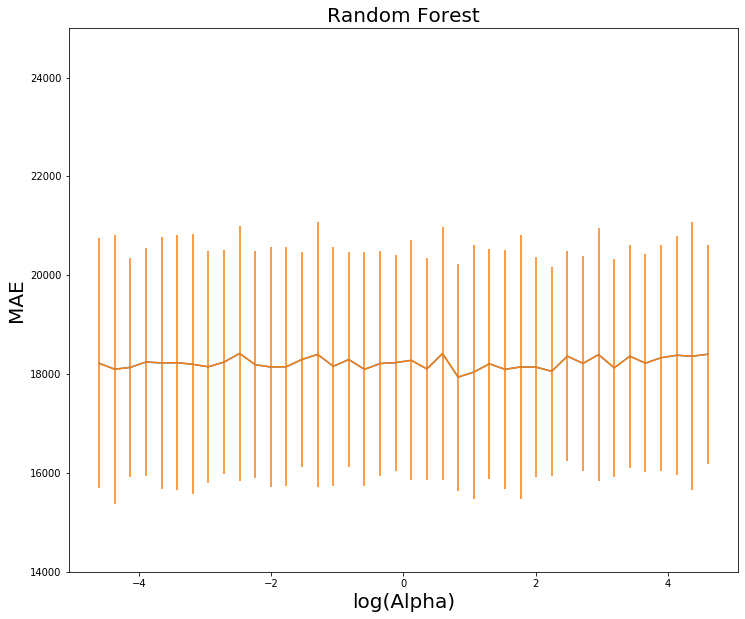

In [156]:
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(rf_model, 40)

plt.figure(figsize=(12,10))
plt.title('Random Forest', fontsize= 20)
plt.plot(np.log(alpha_param), mean_vec)
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel("MAE", fontsize= 20)
plt.xlabel("log(Alpha)", fontsize= 20)
plt.ylim(14000, 25000)
plt.show()

In [ ]:
# print values

# XGBoost

In [48]:
from xgboost import XGBRegressor
model = XGBRegressor(booster='gbtree', 
                     colsample_bylevel=1.0, 
                     colsample_bytree=1.0, 
                     gamma=0.0, 
                     learning_rate=0.1, 
                     max_delta_step=0.0, 
                     max_depth=3, 
                     n_estimators=100, 
                     normalize_type='tree', 
                     num_parallel_tree=1, 
                     n_jobs=-1, 
                     objective='reg:squarederror', 
                     reg_lambda=1.0, 
                     silent=True, 
                     skip_drop=0.0, 
                     subsample=1.0)

Wall time: 0 ns


In [50]:
alpha_param = (10**np.linspace(start=-2, stop=2, num=40))
#Creating a parameters grid
param_grid = [{'reg_alpha': alpha_param }]

xgb_model = GridSearchCV(model, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')
xgb_model.fit(X, y)

[09:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:27:52] WARNING: C:/Users/Administrator/w

[09:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:06] WARNING: C:/Users/Administrator/w

[09:28:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:18] WARNING: C:/Users/Administrator/w

[09:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:31] WARNING: C:/Users/Administrator/w

[09:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:44] WARNING: C:/Users/Administrator/w

[09:28:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:28:57] WARNING: C:/Users/Administrator/w

[09:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:10] WARNING: C:/Users/Administrator/w

[09:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:23] WARNING: C:/Users/Administrator/w

[09:29:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:36] WARNING: C:/Users/Administrator/w

[09:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:48] WARNING: C:/Users/Administrator/w

[09:30:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:30:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:30:01] WARNING: C:/Users/Administrator/w

[09:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:30:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_weights", "normalize_type", "one_drop", "rate_drop", "sample_type", "silent", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:30:14] WARNING: C:/Users/Administrator/w

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=1.0,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    gamma=0.0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=0.0,
                                    max_depth=3, min_child_weight=None,
                                    min_child_weights=1.0, missing=nan,
                                    monotone_constra...
       1.12533558e+00, 1.42510267e+00, 1.80472177e+00, 2.28546386e+00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4

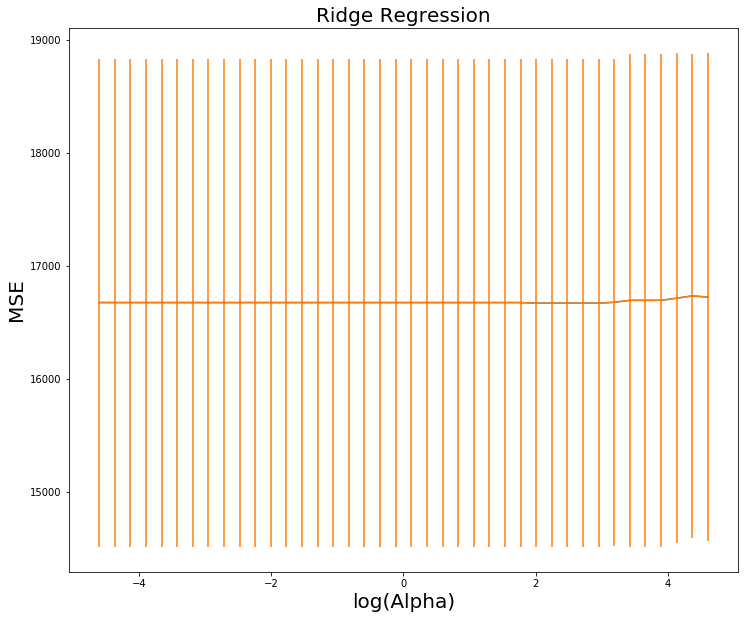

In [69]:
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(xgb_model, 40)

plt.figure(figsize=(12,10))
plt.title('Ridge Regression', fontsize= 20)
plt.plot(np.log(alpha_param), mean_vec)
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel("MSE", fontsize= 20)
plt.xlabel("log(Alpha)", fontsize= 20)
#plt.ylim(14000, 50000)
plt.show()

In [ ]:
#print vals

# LightGBM

In [65]:
import lightgbm
lgb = lightgbm.LGBMRegressor()

In [66]:
alpha_param = (10**np.linspace(start=-2, stop=2, num=40))
#Creating a parameters grid
param_grid = [{'reg_alpha': alpha_param }]

lgb_model = GridSearchCV(lgb, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')
lgb_model.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True...
       1.12533558e+00, 1.42510267e+00, 1.80472177e+00, 2.28546386e+00,
       2.89426612e+00, 3.66524124e+00, 4.64158883e+00, 5.87801607e+00,
       7.44380301e+00, 9.42668455e+00, 1.19377664e+01, 1.51177507e+01,
       1.91448198e+01, 2.42446202e+01, 3.07029063e+01, 3.88815518e+01,
       4.92388263e+01, 6.23550734e+01, 7.89652287e+01, 1.00000000e+02])}

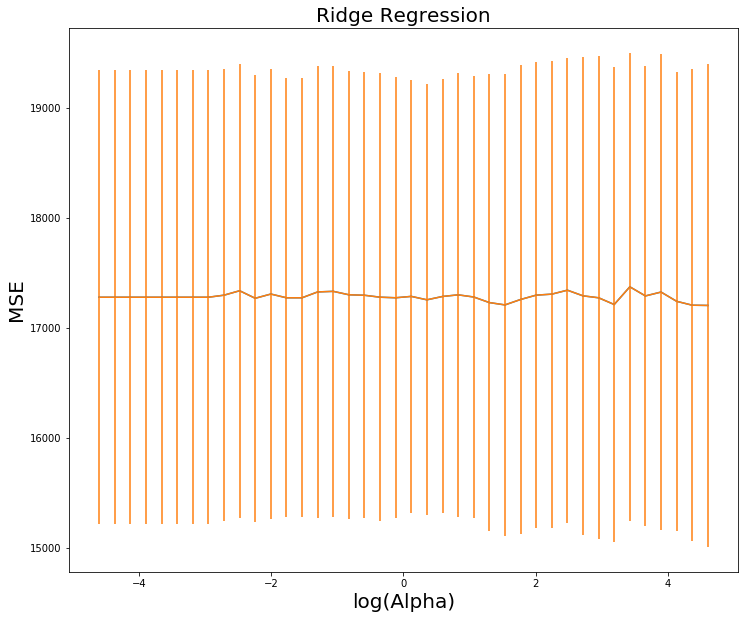

In [68]:
#Calling the vector_values function created to calculate mean and std vectors
mean_vec, std_vec = compute_vectors(lgb_model, 40)

plt.figure(figsize=(12,10))
plt.title('Ridge Regression', fontsize= 20)
plt.plot(np.log(alpha_param), mean_vec)
plt.errorbar(np.log(alpha_param), mean_vec, yerr = std_vec)
plt.ylabel("MSE", fontsize= 20)
plt.xlabel("log(Alpha)", fontsize= 20)
#plt.ylim(14000, 50000)
plt.show()

# Stacking